In [1]:
import os
import numpy as np
from itertools import islice
import pandas as pd

path = './sims/output_fixed/'
extension = '.mco'
dirs = [e.name for e in os.scandir(path)]

wls = np.arange(740, 902, 2)
bin_size = 0.05
dists = np.arange(99)*bin_size
reflectance_lines = 99 # ignore the overflow bin
reflectance_col_header = "Rd_r #Rd[0], [1],..Rd[nr-1]. [1/cm2]\n"

def read_reflectance_data(folder):
    file_names = [folder + '_' + str(e) for e in range(len(wls))]

    result = np.zeros((len(wls), len(dists)))

    for i in range(len(wls)):
        with open(path + folder + '/' + file_names[i] + extension) as lines:
            read_file = lines.readlines()
            col_i = read_file.index(reflectance_col_header)
            result[i, :] = np.genfromtxt(read_file[col_i+1:col_i+reflectance_lines+1])
    
    return result

reflectances = {}
for dir in dirs:
    reflectances[dir] = read_reflectance_data(dir)

In [2]:
len(reflectances.keys())

743

In [2]:
from sklearn.linear_model import LassoLarsIC
from constants.colors import colors
import matplotlib.pyplot as plt

def generate_summary_statistics(distances, suffixes):
    summary_statistics = {k: {} for k in dirs}
    for key, e in reflectances.items():
        ys = [e[:, dist] for dist in distances]
        y_primes = [transform_data(y) for y in ys]

        splines = [make_lsq_spline(wls, y, t=knots) for y in ys]

        coeffs = np.array([y.c for y in splines])

        # spline coeffs for fits to y_prime
        for suffix, coeff in zip(suffixes, coeffs):
            summary_statistics[key]['spline_' + suffix] = coeff
        
        # gradients of spline fits at central_knots
        for suffix, y in zip(suffixes, splines):
            summary_statistics[key]['spline_gradient_' + suffix] = np.diag(approx_fprime(gradient_knots, y))
        
        # differences in log(mean) of y
        log_means = [np.log(np.mean(y)) for y in ys]
        summary_statistics[key]['log_mean'] = np.diff(log_means)
        
        for suffix, y in zip(suffixes, ys):
            summary_statistics[key]['mean_' + suffix] = np.mean(y)
            summary_statistics[key]['variance_' + suffix] = np.var(np.log(y))
            summary_statistics[key]['minimax_' + suffix] = np.array([np.max(y), np.min(y)])
            summary_statistics[key]['minimaxwl_' + suffix] = np.array([wls[np.argmax(y)], wls[np.argmin(y)]])
    
    return summary_statistics

def run_whole_thing(distances, df, target_col, extra_powers=[2], filter_fun=None):
    suffixes = [str(e) for e in range(len(distances))]
    summary_statistics = generate_summary_statistics(distances, suffixes)

    def build_summary_stat_x(uuid):
        summary = summary_statistics[uuid]
        summary_stats = [np.atleast_1d(summary[key + '_' + suffix]) for key in ['variance', 'spline'] for suffix in suffixes] + [summary[key] for key in ['log_mean']]
        base_stats = np.concatenate(summary_stats)
        return np.concatenate([base_stats] + [np.power(base_stats, e) for e in extra_powers])
    
    for key in ['one', 'two']:
        df[f'oxy_blood_{key}'] = df[f'blood_{key}']*df[f'blood_sat_{key}']
        df[f'deoxy_blood_{key}'] = df[f'blood_{key}']*(1 - df[f'blood_sat_{key}'])
    df = df[[target_col, 'uuid']]

    df = df[df.loc[:, 'uuid'].apply(lambda uuid: uuid in reflectances)]
    if filter_fun is not None:
        df = df[df.loc[:, 'uuid'].apply(filter_fun)]
    df.loc[:, 'x'] = df.loc[:, 'uuid'].apply(build_summary_stat_x)

    y = np.zeros(len(df))
    mat = np.zeros((len(df), len(df['x'].iloc[0])))

    print('mat shape:', mat.shape)

    for i, (_, row) in enumerate(df.iterrows()):
        y[i] = row[target_col]
        mat[i, :] = row['x']

    model = LassoLarsIC(normalize=True).fit(mat, y)

    print("fit model with alpha_:", model.alpha_)
    print("AIC = ", np.min(model.criterion_))

    # matrix eqn y = mat @ beta

    #beta = np.linalg.pinv(mat) @ y
    beta = model.coef_

    # model y as mat @ beta

    summary_stat = mat @ beta

    df.loc[:, 'summary_stat'] = df.loc[:, 'x'].apply(lambda x: np.sum(x * beta) + model.intercept_)

    return y, summary_stat, df, model

def fit_gp(x, y):
    pass

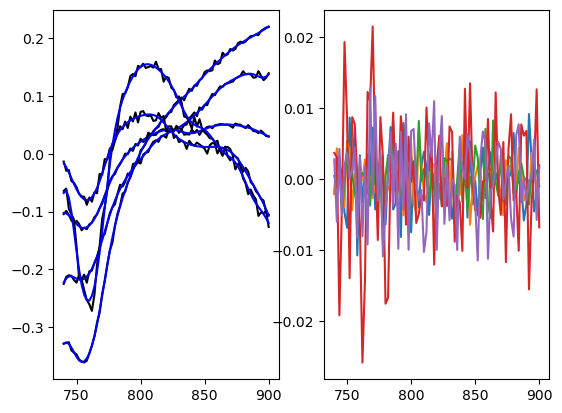

In [3]:
import matplotlib.pyplot as plt
from scipy.interpolate import make_lsq_spline
from scipy.optimize import approx_fprime

degree = 3
n_knots = 14
central_knots = np.linspace(min(wls), max(wls), n_knots)
knots = np.r_[[min(wls)]*3, central_knots, [max(wls)]*3]

n_grads = 50
gradient_knots = np.linspace(min(wls), max(wls), 5)

def transform_data(y):
    y_prime = np.log(y)
    y_prime = y_prime - np.mean(y_prime)
    return y_prime

dist_i = 20
fig, axs = plt.subplots(nrows=1, ncols=2)
for key, e in islice(reflectances.items(), 5):
    y = transform_data(e[:, dist_i])
    spline = make_lsq_spline(wls, y, t=knots)
    
    axs[0].plot(wls, y, color='black')
    axs[0].plot(wls, spline(wls), color='blue')

    axs[1].plot(wls, y - spline(wls))

plt.show()

mat shape: (743, 106)
fit model with alpha_: 1.081697037096891e-05
AIC =  4695.825360703182


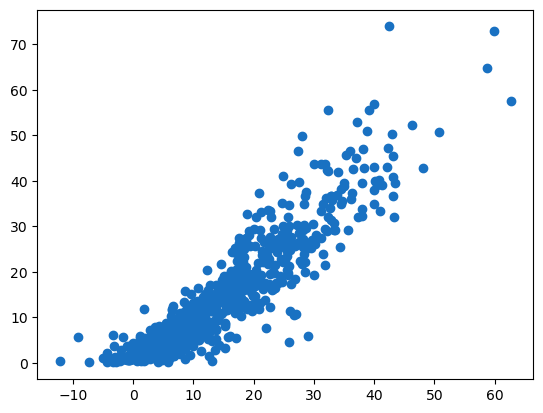

In [4]:
df = pd.read_csv('./sims/df_fixed.csv', index_col=0)

target = 'deoxy_blood_one'
y, summary_stat, df_, _ = run_whole_thing([40, 45, 50], df, target)

plt.figure()
plt.scatter(df_['summary_stat'], df_[target], color=colors['blue'][8])
plt.show()

In [5]:
len(reflectances.keys())

743

In [27]:
point_style_kwargs = {
    "color": colors['blue'][8],
    "alpha": 0.7,
    "edgecolors": 'black'
}

def add_top_left_text(label, ax):
    t = ax.text(0.025, 0.975, label, verticalalignment='top', fontsize=14, transform=ax.transAxes)
    #t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='black'))

def add_bottom_right_text(label, ax, fill=None, alpha=0.5, edgecolor='black'):
    t = ax.text(0.975, 0.025, label, verticalalignment='bottom', horizontalalignment='right', fontsize=12, transform=ax.transAxes)
    if fill is not None:
        t.set_bbox(dict(facecolor=fill, alpha=0.7, edgecolor=edgecolor))

def fit_text(model):
    aic_string = f'AIC = {str(np.round(np.min(model.criterion_), 1))} '
    alpha_string = r'$\alpha = ' + '{:0.1e}'.format(model.alpha_).replace('e', 'x 10^{') + '}$'
    combined_string = '\n'.join([aic_string, alpha_string])

    return aic_string, alpha_string, combined_string

def pairwise(iterable, N=1):
    "s -> (s0, s1), (s2, s3), (s4, s5), ..."
    a = iter(iterable)
    b = iter(iterable)
    for _ in range(N-1):
        next(b)
    return zip(a, b)

# make the mean line smooth and add a legend to each figure for mean and std
def std_fill(ax, x, y, color):
    x = np.array(x)
    n_bins = 100
    bins = np.linspace(min(x), max(x), 100)
    epsilon = (max(x) - min(x)) / 10
    n_steps = int(epsilon / (bins[1] - bins[0]))
    print(f'epsilon = {epsilon}')
    bins_x = []
    bins_y = []
    std_y = []
    for lower, upper in pairwise(bins, N=n_steps):
        mask = (lower < x) & (x < upper)
        subset_x = x[mask]
        if len(subset_x) < 5:
            continue
        subset_y = y[mask]
        bins_y.append(np.mean(subset_y))
        std_y.append(np.std(subset_y))
        bins_x.append((lower + upper) / 2)
    
    fill = ax.fill_between(bins_x, np.array(bins_y) - np.array(std_y), np.array(bins_y) + np.array(std_y), color=color)

    return bins_x, bins_y, std_y, epsilon, fill

mat shape: (560, 85)
fit model with alpha_: 0.00027354222371187757
AIC =  4839.627078071594
epsilon = 6.18067229587707
std_y = 13.031859923521052 12.3086285912529 13.45901536604557 13.286272329122525 14.49236719411644 14.124288886410021 13.912673597543282 13.62415728452066 13.181512614223779 12.860850598058793 13.5153225116715 13.294718278711594 13.200542204810235 14.59116016904375 15.322512720654297 16.537858967945695 16.698321602998863 17.934761956631196 17.41446737764269 18.45409346778154 17.961196967395644 17.972099455516858 17.612633370916292 17.129999687953312 17.975105347503902 18.618338255540944 18.656020319173944 18.505630430880203 18.378650928148147 18.317561705940566 18.77485934613027 18.56302287697306 18.204374353664033 17.43593556140254 17.43279397734961 16.7631087773831 16.60039329782755 16.45339184471071 15.178860369463605 17.842287195573714 16.789056703013564 13.517069612123759 15.882509520000553 16.73920068832261 15.617876473671163 15.538277008723078 16.606288400180038

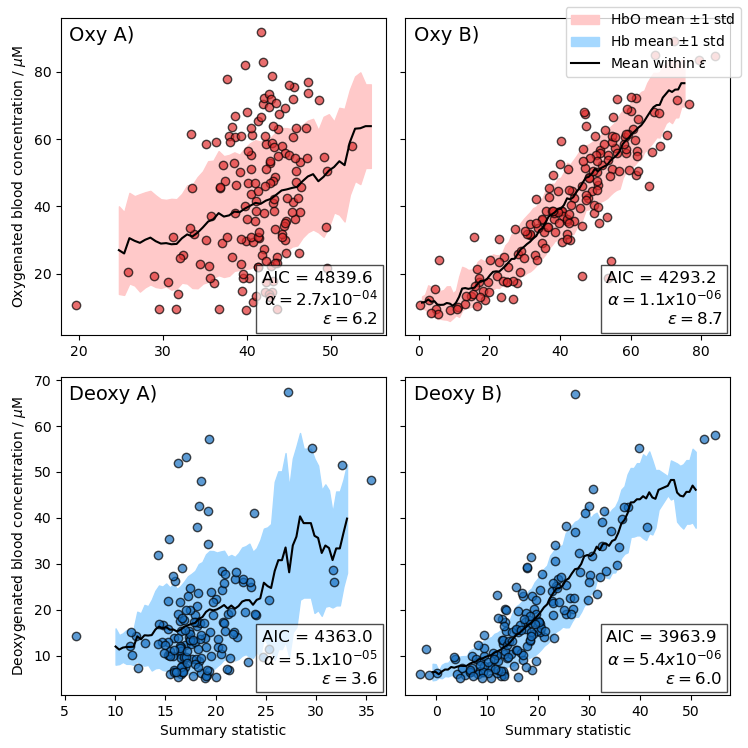

In [35]:
distances = [
    [40],
    [40, 60],
]

powers = [
    [2, 3, 4, 5],
    [2, 3, 4, 5],
]

labels = [['Oxy A)', 'Oxy B)'], ['Deoxy A)', 'Deoxy B)']]
scatter_colors = [colors['red'], colors['blue']]
targets = ['oxy_blood_two', 'deoxy_blood_two']
y_labels = [r'Oxygenated blood concentration / $\mu$M', r'Deoxygenated blood concentration / $\mu$M']

uuid_index_df = df.set_index('uuid')

def filter_fun(uuid):
    row = uuid_index_df.loc[uuid]
    sat = row['blood_two'] * row['blood_sat_two']
    unsat = row['blood_two'] * (1 - row['blood_sat_two'])
    return sat > 5 and unsat > 5

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(7.5, 7.5), sharey='row')

lines = []
shading = []

for i, ax_row in enumerate(axs):
    ax_row[0].set_ylabel(y_labels[i])
    for j, ax in enumerate(ax_row):
        _, _, df_, model = run_whole_thing(distances[j], df, targets[i], extra_powers=powers[i], filter_fun=filter_fun)
        x, y = df_['summary_stat'], df_[targets[i]]
        bins_x, bins_y, std_y, epsilon, fill = std_fill(ax, x, y, scatter_colors[i][2])
        shading.append(fill)
        print('std_y = ' + ' '.join([str(x) for x in std_y]))
        
        kwargs = point_style_kwargs.copy()
        kwargs['color'] = scatter_colors[i][8]
        p = 0.3
        mask = np.random.choice([False, True], size=len(x), p=[1-p, p])

        x = x[mask]
        y = y[mask]

        ax.scatter(x, y, **kwargs)
        add_top_left_text(labels[i][j], ax)
        _, _, combined_string =  fit_text(model)
        add_bottom_right_text(combined_string + '\n' + r'$\epsilon =$' + str(round(epsilon, 1)), ax, fill='white')
        if i == 1:
            ax.set_xlabel('Summary statistic')
        
        mean, = ax.plot(bins_x, bins_y, 'black')

fig.legend((shading[0], shading[2], mean), (r'HbO mean $\pm$1 std', r'Hb mean $\pm$1 std', r'Mean within $\epsilon$'))
plt.tight_layout()
plt.savefig('./figure_generation/figures/second_layer_fixed_inference.png', dpi=600, transparent=True)
plt.savefig('./figure_generation/figures/second_layer_fixed_inference.pdf', dpi=600, transparent=True)
plt.show()